<a href="https://colab.research.google.com/github/Wnjoki/ewcefOAeo7tEyNDX-ValueInvestor/blob/main/ValueInvestor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statistics
import random

# ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

# LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Warnings
import warnings

# Suppress deprecation warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

#Data Processing

In [2]:
#Data Loading
file_name = r"/content/2020Q1Q2Q3Q4-2021Q1.xlsx"
xlsx = pd.ExcelFile(file_name)

#Get the lists of sheet names which are companies' names
Comp_names = xlsx.sheet_names


# Create an empty list to store dataframes
dataframes = []

# Loop through each sheet and store data in dataframes list
for company in Comp_names:
    df = xlsx.parse(company, skipfooter=1)  # Load the sheet into a dataframe
    df['Company'] = company  # Add a column to identify the company
    dataframes.append(df)  # Append the dataframe to the list


# Combine the dataframes into a single dataframe and get the first two
df = pd.concat(dataframes[:2], ignore_index=True)

In [3]:
df.head()


,Date,Price,Open,High,Low,Vol.,Change %,Company
0,2021-03-31,291.02,294.00,294.42,290.26,47.00M,-0.0076,Russia - Sberbank Rossii PAO (S
1,2021-03-30,293.25,294.86,295.72,291.50,38.81M,-0.0002,Russia - Sberbank Rossii PAO (S
2,2021-03-29,293.30,289.72,294.09,289.26,43.68M,0.0071,Russia - Sberbank Rossii PAO (S
3,2021-03-26,291.22,288.63,292.75,288.32,56.07M,0.0159,Russia - Sberbank Rossii PAO (S
4,2021-03-25,286.66,286.50,287.03,283.85,35.22M,0.0030,Russia - Sberbank Rossii PAO (S


In [4]:
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %,Company
621,2020-01-08,19.94,19.89,19.95,19.66,2.79M,0.0005,Turkey - Koc Holding AS (KCHOL)
622,2020-01-07,19.93,20.22,20.28,19.92,2.89M,-0.0075,Turkey - Koc Holding AS (KCHOL)
623,2020-01-06,20.08,20.34,20.34,19.97,1.94M,-0.0108,Turkey - Koc Holding AS (KCHOL)
624,2020-01-03,20.30,20.30,20.44,19.97,3.31M,-0.0039,Turkey - Koc Holding AS (KCHOL)
625,2020-01-02,20.38,20.42,20.44,20.24,2.53M,0.0030,Turkey - Koc Holding AS (KCHOL)


We will look at the Russi-Sberbank Rossil PAO(SBER) and Turkey - Koc Holding AS (KCHOL)

In [5]:
#data structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      626 non-null    datetime64[ns]
 1   Price     626 non-null    float64       
 2   Open      626 non-null    float64       
 3   High      626 non-null    float64       
 4   Low       626 non-null    float64       
 5   Vol.      626 non-null    object        
 6   Change %  626 non-null    float64       
 7   Company   626 non-null    object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 39.2+ KB


In [6]:
#statistical analysis
df.describe()

,Price,Open,High,Low,Change %
count,626.000000,626.000000,626.000000,626.000000,626.000000
mean,125.498482,125.456805,127.030304,123.804473,0.000407
std,110.765726,110.699657,111.991476,109.340270,0.023083
min,12.790000,12.970000,13.110000,12.380000,-0.099400
25%,17.580000,17.617500,17.852500,17.435000,-0.012000
50%,23.630000,23.660000,24.240000,23.350000,0.000650
75%,228.597500,228.970000,231.637500,226.265000,0.014225
max,293.300000,294.860000,296.070000,291.500000,0.129000


**Data Cleaning**

Handle missing values.

Ensure data consistency (e.g., stock prices should be non-negative).




In [7]:
#check the number of missing values for each column
missing_values = df.isnull().sum()
print(missing_values)


Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
Company     0
dtype: int64


No missing Values in the data set

From the statistical analysis,no price have a negative value

In [8]:
# Convert 'Vol.' column to a consistent format
def volume_conversion(vol):
    if 'M' in vol:
        return float(vol.replace('M', '')) * 1_000_000
    elif 'K' in vol:
        return float(vol.replace('K', '')) * 1_000
    elif vol == '-':
        return None  # Convert '-' to NaN
    else:
        return float(vol)

df['Vol.'] = df['Vol.'].astype(str).apply(volume_conversion)

df['Vol.']


0      47000000.0
1      38810000.0
2      43680000.0
3      56070000.0
4      35220000.0
          ...    
621     2790000.0
622     2890000.0
623     1940000.0
624     3310000.0
625     2530000.0
Name: Vol., Length: 626, dtype: float64

In [9]:
# Convert 'Change %' to a float
# (remove the '%' sign and divide by 100)
df['Change'] = df['Change %'].astype(str).str.rstrip('%').astype('float')/ 100.0
df['Change']

0     -0.000076
1     -0.000002
2      0.000071
3      0.000159
4      0.000030
         ...   
621    0.000005
622   -0.000075
623   -0.000108
624   -0.000039
625    0.000030
Name: Change, Length: 626, dtype: float64

#Exploratory Data Analysis

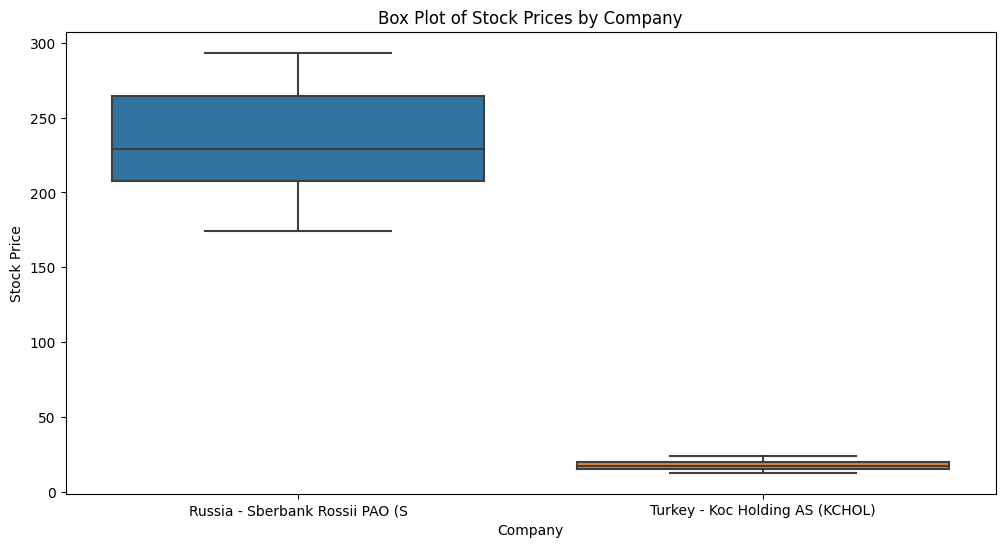

In [10]:
#plotting a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Company', y='Price', data=df)
plt.title('Box Plot of Stock Prices by Company')
plt.xlabel('Company')
plt.ylabel('Stock Price')
#plt.xticks(rotation=45)
plt.show()

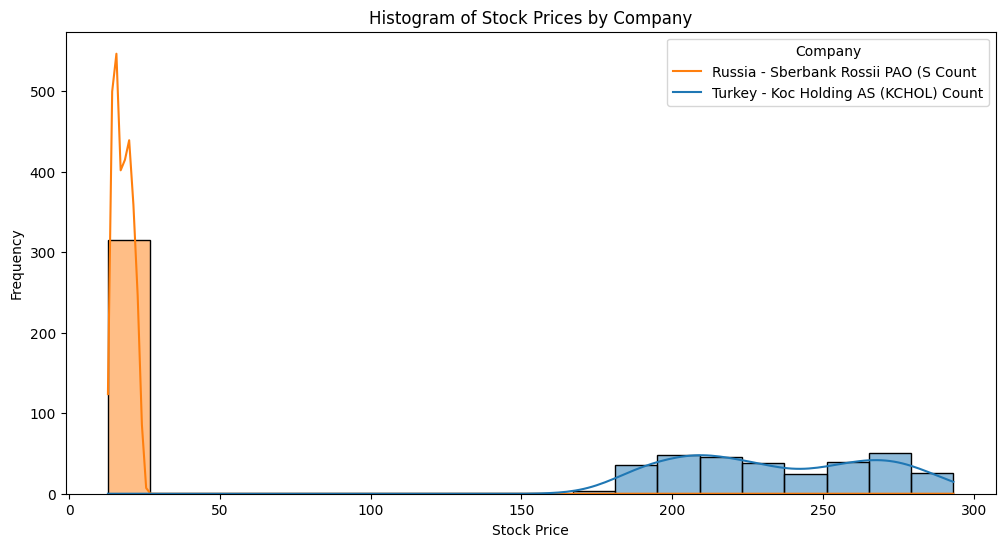

In [11]:
#Visualization
# Create a histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Price', hue='Company', kde=True,bins=20)
companies = df['Company'].unique()# Get the unique company names from your DataFrame

# Create custom legend labels
legend_labels = [f'{company} Count' for company in companies]

# Set the legend labels and title
plt.title('Histogram of Stock Prices by Company')
plt.xlabel('Stock Price')
plt.ylabel('Frequency')
plt.legend(legend_labels,title='Company')
plt.show()

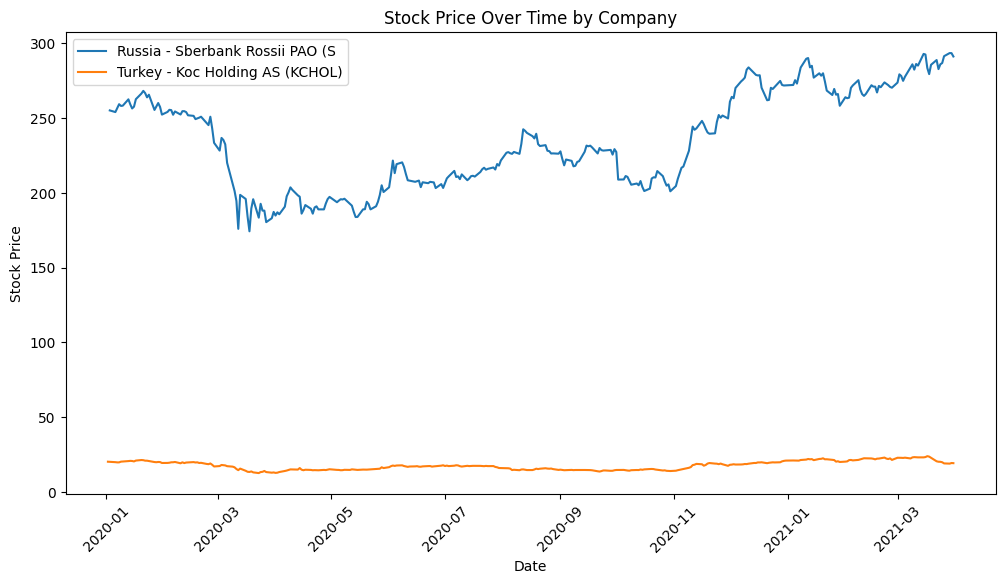

In [12]:
#line chart
# Set the 'Date' column as the index
#df.set_index('Date', inplace=True)

plt.figure(figsize=(12, 6))
for company, data in df.groupby('Company'):
    plt.plot(data['Date'], data['Price'], label=company)
plt.title('Stock Price Over Time by Company')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

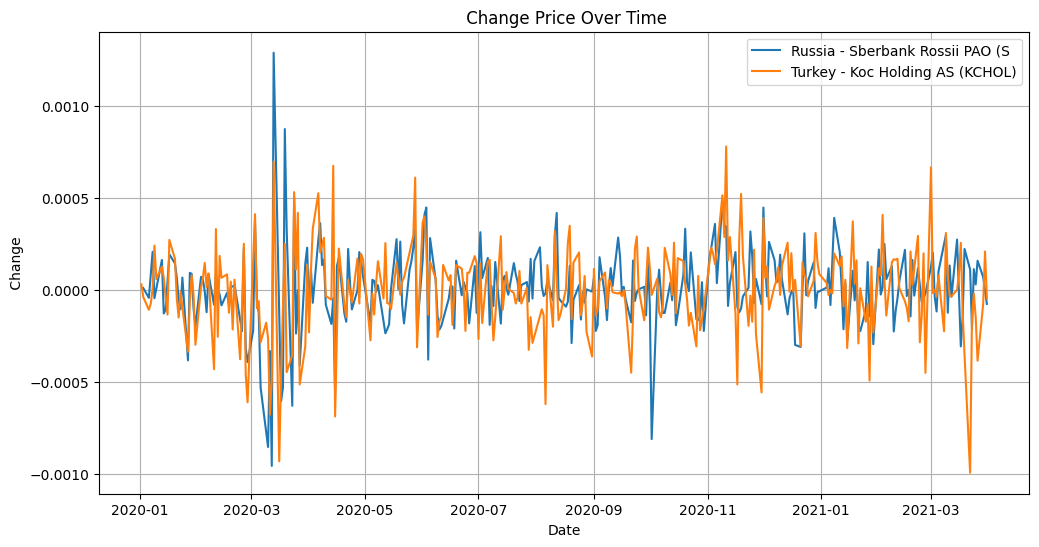

In [13]:

# Create a line chart for percentage changes
plt.figure(figsize=(12, 6))
for company, data in df.groupby('Company'):
    plt.plot(data['Date'], data['Change'], label=company)

# Customize the plot
plt.title(f' Change Price Over Time')
plt.xlabel('Date')
plt.ylabel(' Change ')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

#Feature Engineering

In [14]:
#Drop columns that are not relevant
colns=['Open','High',	'Low',	'Vol.', 'Change %','Change']
df = df.drop(columns=colns)



**Moving averages**

A moving average is  used as a statistical calculation in time-series analysis and data analysis in general. It is used to smooth out fluctuations in data and identify trends or patterns over time.

Types of moving averages, including the simple moving average (SMA) and the exponential moving average (EMA).



Simple Moving average

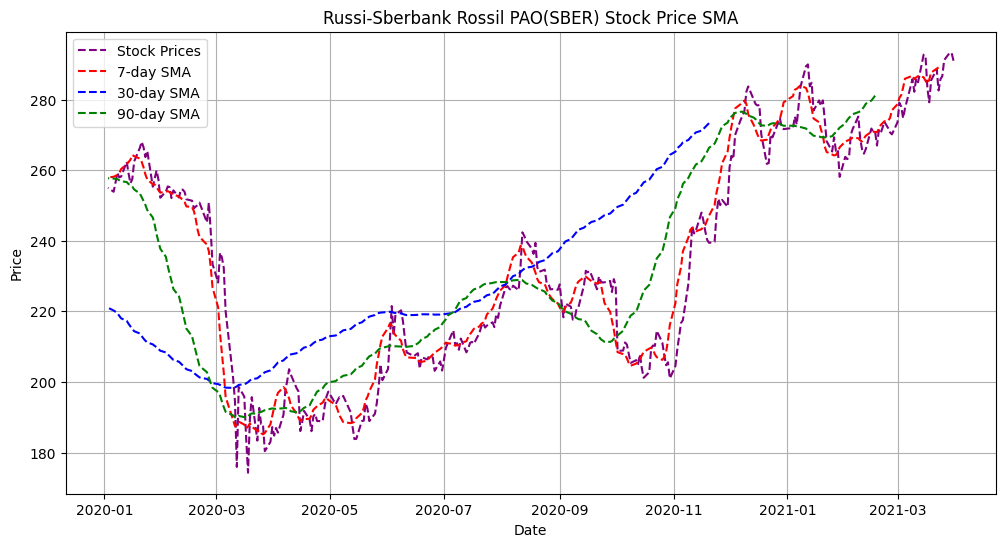

In [15]:

#filter each company's data
#Russi-Sberbank Rossil PAO(SBER) and Turkey - Koc Holding AS (KCHOL)
SBER_data = df[df['Company'] == 'Russia - Sberbank Rossii PAO (S'].copy()
KCHOL_data = df[df['Company'] == 'Turkey - Koc Holding AS (KCHOL)'].copy()

def moving_averages(df, window):
    return df['Price'].rolling(window=window).mean()

# Calculate moving averages
#7-day MA
SBER_data['7-day MA'] = moving_averages(SBER_data, 7)
KCHOL_data['7-day MA'] = moving_averages(KCHOL_data, 7)

#30-Day MA
SBER_data['30-day MA'] = moving_averages(SBER_data, 30)
KCHOL_data['30-day MA'] = moving_averages(KCHOL_data, 30)

#90-Day MA
SBER_data['90-day MA'] = moving_averages(SBER_data, 90)
KCHOL_data['90-day MA'] = moving_averages(KCHOL_data, 90)

plt.figure(figsize=(12, 6))
plt.plot(SBER_data['Date'], SBER_data['Price'], label='Stock Prices',color='purple', linestyle='--')
plt.plot(SBER_data['Date'], SBER_data['7-day MA'], label='7-day SMA',color='red', linestyle='--')
plt.plot(SBER_data['Date'], SBER_data['90-day MA'], label='30-day SMA',color='blue', linestyle='--')
plt.plot(SBER_data['Date'], SBER_data['30-day MA'], label='90-day SMA',color='green', linestyle='--')


plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Russi-Sberbank Rossil PAO(SBER) Stock Price SMA')
plt.legend(loc='upper left')
plt.legend()
plt.grid(True)
plt.show()


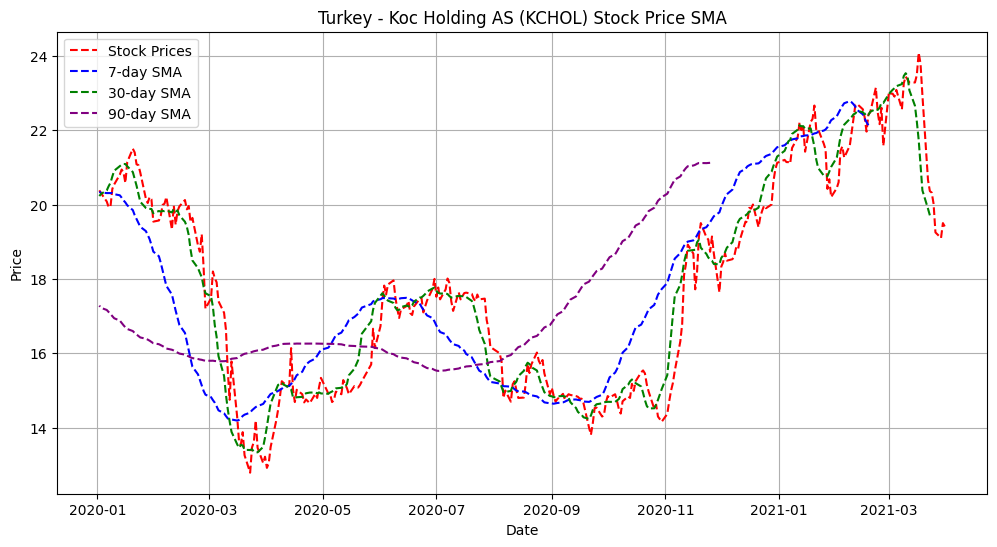

In [16]:
#Turkey - Koc Holding AS (KCHOL) Stock Price SMA plot
plt.figure(figsize=(12, 6))
plt.plot(KCHOL_data['Date'], KCHOL_data['Price'], label='Stock Prices',color='red', linestyle='--')
plt.plot(KCHOL_data['Date'], KCHOL_data['30-day MA'], label='7-day SMA',color='blue', linestyle='--')
plt.plot(KCHOL_data['Date'], KCHOL_data['7-day MA'], label='30-day SMA',color='green', linestyle='--')
plt.plot(KCHOL_data['Date'], KCHOL_data['90-day MA'], label='90-day SMA',color='purple', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Turkey - Koc Holding AS (KCHOL) Stock Price SMA')
plt.legend()
plt.grid(True)
plt.show()

Exponential Moving Average

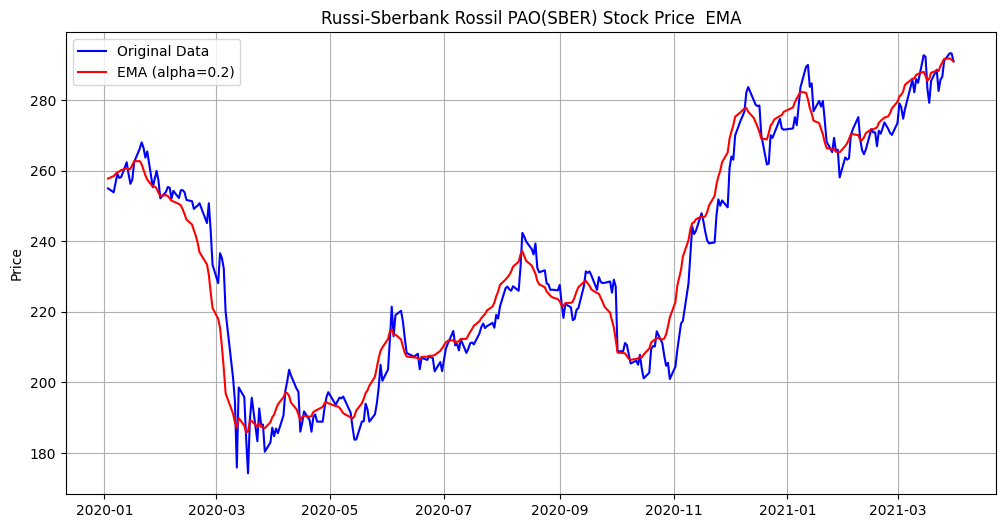

In [18]:
alpha = 0.2
SBER_data['EMA'] = SBER_data['Price'].ewm(alpha=alpha, adjust=False).mean()


# Create a plot to visualize the original data and the EMA
plt.figure(figsize=(12, 6))
plt.plot(SBER_data['Date'], SBER_data['Price'], label='Original Data', color='blue')
plt.plot(SBER_data['Date'], SBER_data['EMA'], label=f'EMA (alpha={alpha})', color='red')
plt.title('Russi-Sberbank Rossil PAO(SBER) Stock Price  EMA')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

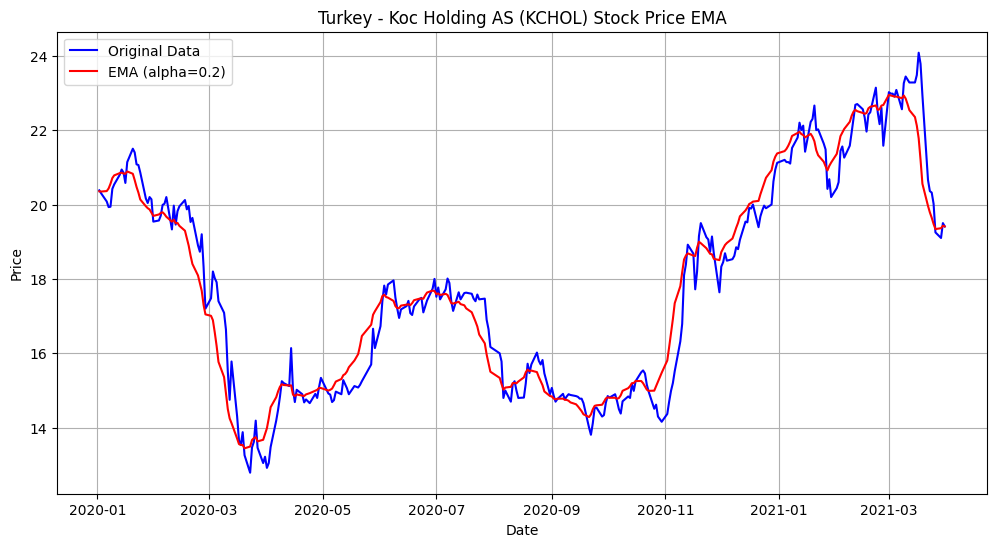

In [19]:
alpha = 0.2
KCHOL_data['EMA'] = KCHOL_data['Price'].ewm(alpha=alpha, adjust=False).mean()


# Create a plot to visualize the original data and the EMA
plt.figure(figsize=(12, 6))
plt.plot(KCHOL_data['Date'], KCHOL_data['Price'], label='Original Data', color='blue')
plt.plot(KCHOL_data['Date'], KCHOL_data['EMA'], label=f'EMA (alpha={alpha})', color='red')
plt.title('Turkey - Koc Holding AS (KCHOL) Stock Price EMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

**Relative Strength Index**



It measures the speed and change of price movements. RSI oscillates between zero and 100 and is typically used to identify overbought or oversold conditions.

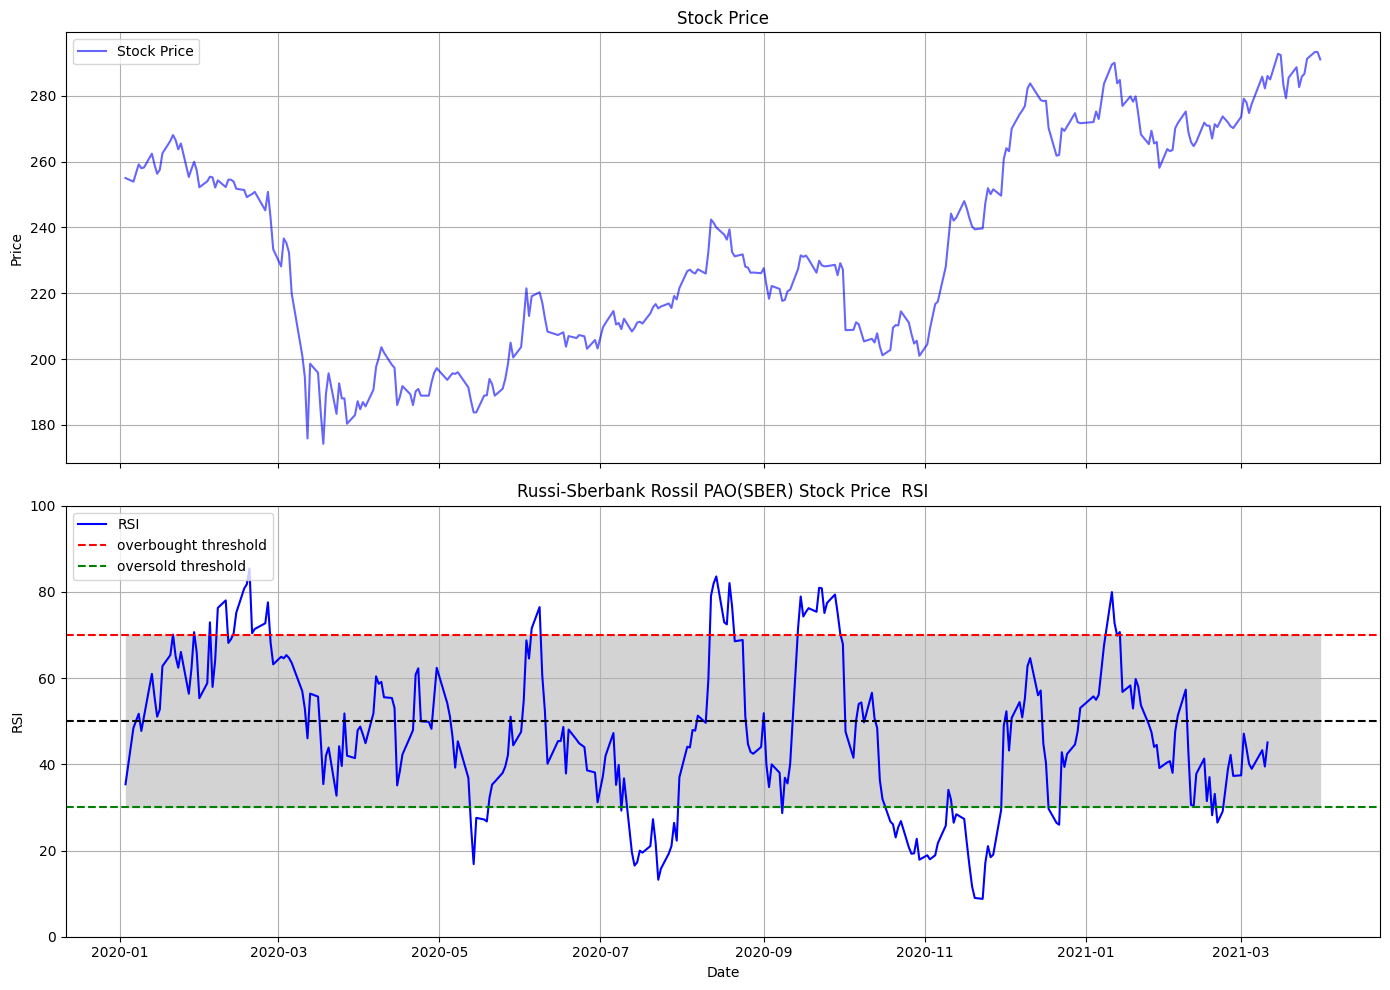

In [20]:
#Define  RSI function
def rsi(data, window):
  delta = data.diff()
  up, down = delta.copy(), delta.copy()
  up[up < 0] = 0
  down[down > 0] = 0

  roll_up = up.rolling(window=window).mean()
  roll_down = down.abs().rolling(window=window).mean()

  RS = roll_up / roll_down
  RSI = 100.0 - (100.0 / (1.0 + RS))

  return RSI

SBER_data['RSI'] = rsi(SBER_data['Price'], 14)

#plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plotting the stock price on the first subplot
ax1.plot(SBER_data['Date'], SBER_data['Price'], label='Stock Price', color='blue', alpha=0.6)
ax1.set_title('Stock Price')
ax1.set_ylabel('Price')
ax1.grid(True)
ax1.legend(loc='upper left')

# Plotting the RSI on the second subplot
ax2.plot(SBER_data['Date'], SBER_data['RSI'], label='RSI', color='blue')

# Adding the overbought threshold
ax2.axhline(70, color='red',label='overbought threshold', linestyle='--')

# Adding the oversold threshold
ax2.axhline(30, color='green', label ='oversold threshold',linestyle='--')

# Adding the neutral line
ax2.axhline(50, color='black', linestyle='--')

ax2.fill_between(SBER_data['Date'], y1=30, y2=70, color='lightgray')

ax2.set_title('Russi-Sberbank Rossil PAO(SBER) Stock Price  RSI')
ax2.set_xlabel('Date')
ax2.set_ylabel('RSI')
ax2.set_ylim([0, 100])
ax2.grid(True)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()


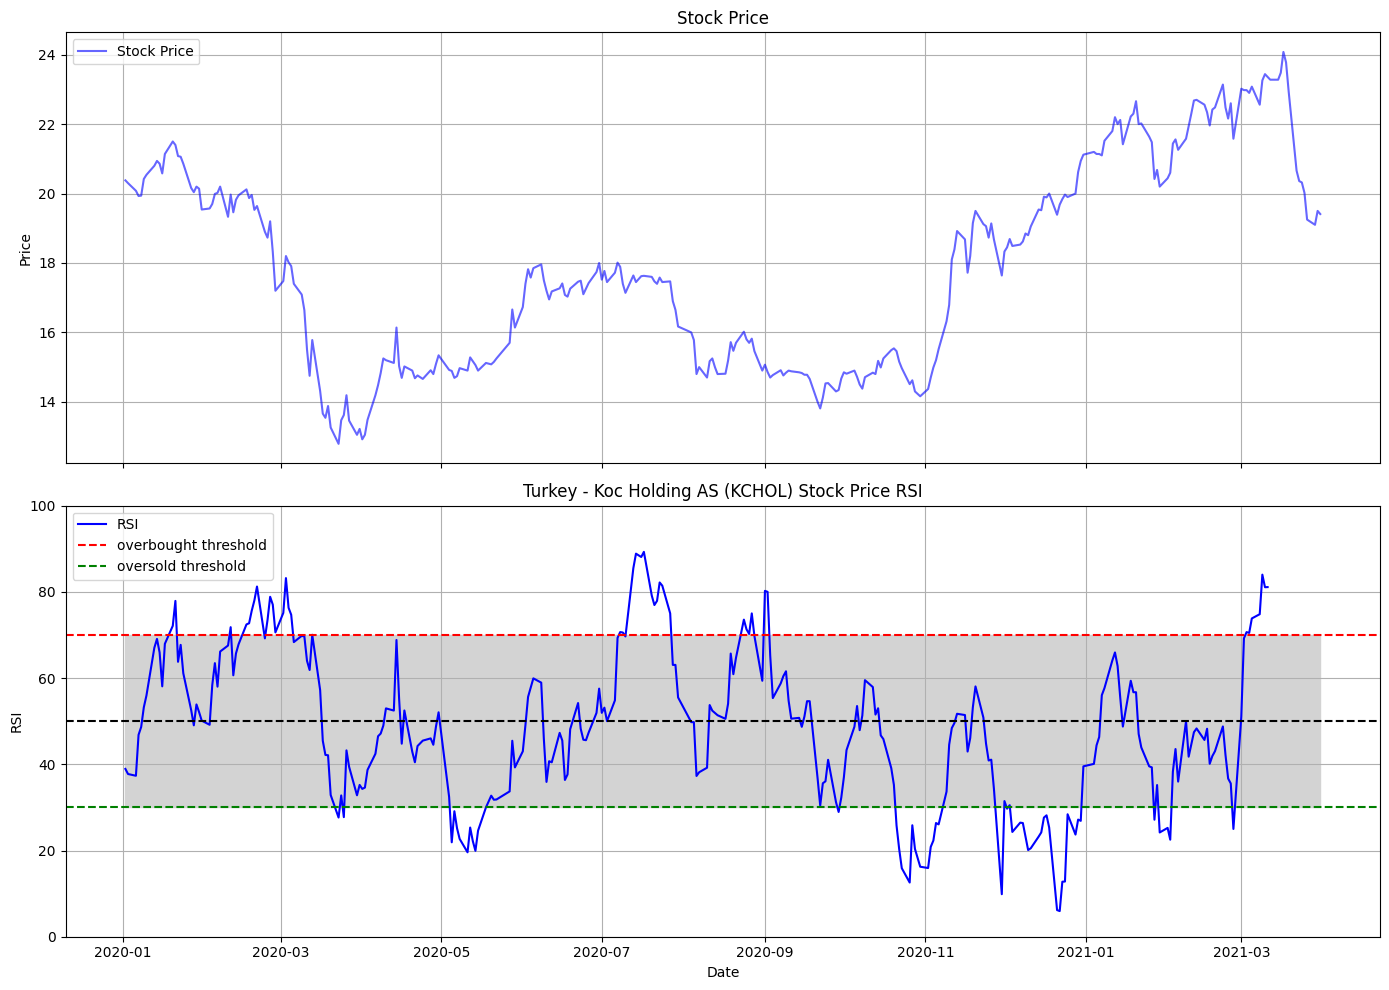

In [21]:
#Define  RSI function
def rsi(data, window):
  delta = data.diff()
  up, down = delta.copy(), delta.copy()
  up[up < 0] = 0
  down[down > 0] = 0

  roll_up = up.rolling(window=window).mean()
  roll_down = down.abs().rolling(window=window).mean()

  RS = roll_up / roll_down
  RSI = 100.0 - (100.0 / (1.0 + RS))

  return RSI

KCHOL_data['RSI'] = rsi(KCHOL_data['Price'], 14)

#plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plotting the stock price on the first subplot
ax1.plot(KCHOL_data['Date'], KCHOL_data['Price'], label='Stock Price', color='blue', alpha=0.6)
ax1.set_title('Stock Price')
ax1.set_ylabel('Price')
ax1.grid(True)
ax1.legend(loc='upper left')

# Plotting the RSI on the second subplot
ax2.plot(KCHOL_data['Date'], KCHOL_data['RSI'], label='RSI', color='blue')

# Adding the overbought threshold
ax2.axhline(70, color='red', label='overbought threshold', linestyle='--')

# Adding the oversold threshold
ax2.axhline(30, color='green',label='oversold threshold',  linestyle='--')

# Adding the neutral line
ax2.axhline(50, color='black', linestyle='--')

ax2.fill_between(KCHOL_data['Date'], y1=30, y2=70, color='lightgray')

ax2.set_title('Turkey - Koc Holding AS (KCHOL) Stock Price RSI')
ax2.set_xlabel('Date')
ax2.set_ylabel('RSI')
ax2.set_ylim([0, 100])
ax2.grid(True)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()


**Moving Average Convergence Divergence**

Momentum indicator that shows the relationship between two moving averages.

It consists of two main components:

    MACD line
    Signal line

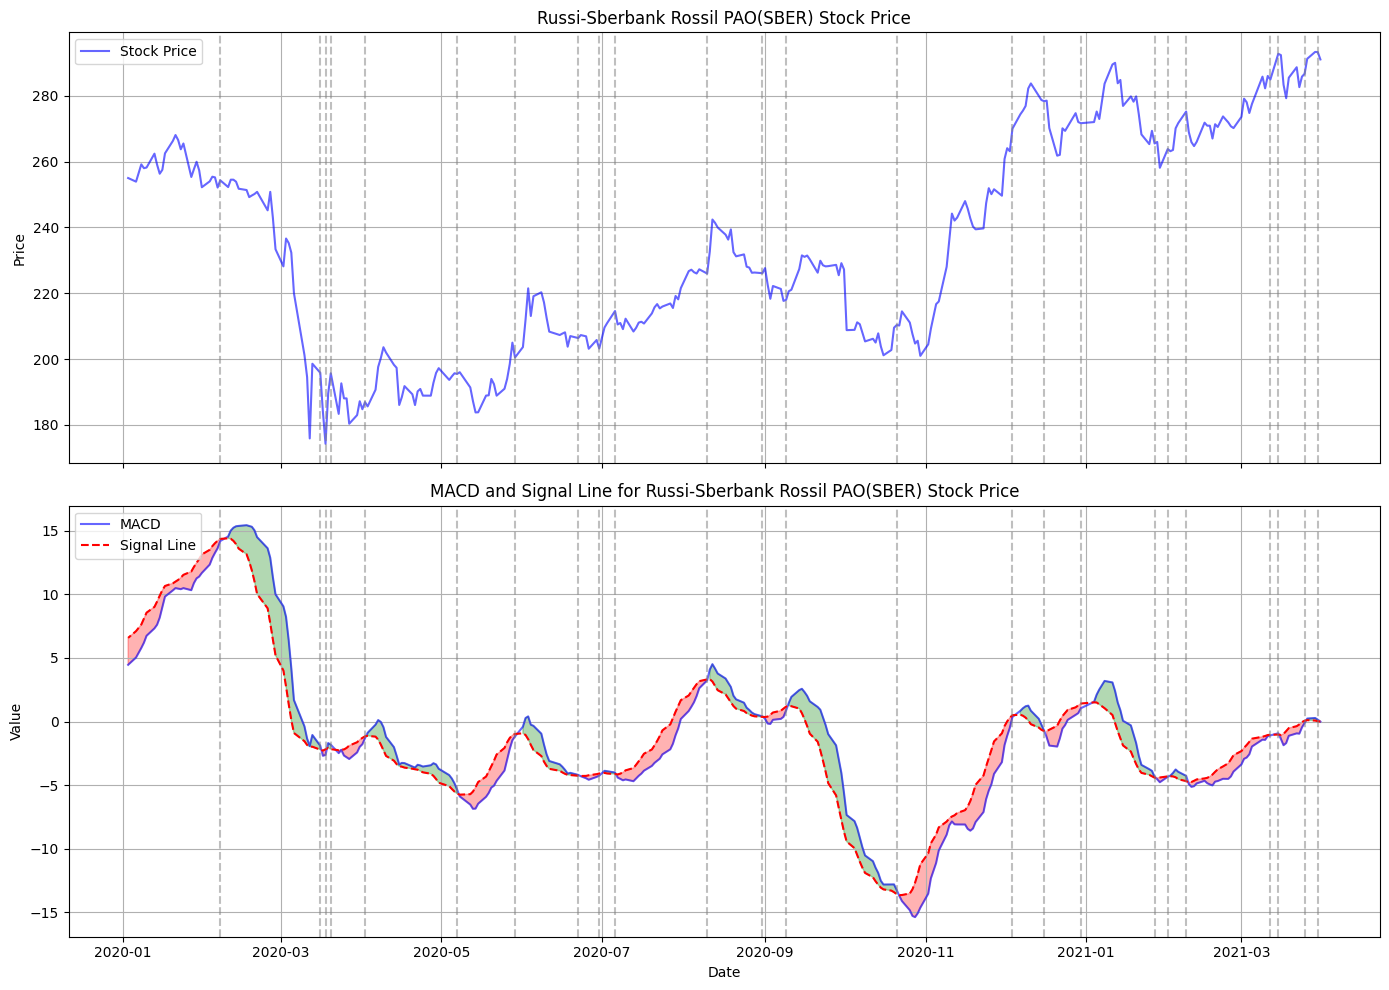

In [22]:
# Calculate the Short Term Exponential Moving Average
SBER_data['14_EMA'] = SBER_data['Price'].ewm(span=14, adjust=False).mean()

# Calculate the Long Term Exponential Moving Average
SBER_data['30_EMA'] = SBER_data['Price'].ewm(span=30, adjust=False).mean()

# Calculate MACD
SBER_data['MACD'] = SBER_data['14_EMA'] - SBER_data['30_EMA']

# Calculate Signal Line
SBER_data['Signal_Line'] = SBER_data['MACD'].ewm(span=9, adjust=False).mean()

#plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plotting the stock price on the first subplot
ax1.plot(SBER_data['Date'], SBER_data['Price'], label='Stock Price', color='blue', alpha=0.6)
ax1.set_title('Russi-Sberbank Rossil PAO(SBER) Stock Price' )
ax1.set_ylabel('Price')
ax1.grid(True)
ax1.legend(loc='upper left')

# Plotting the MACD and Signal Line on the second subplot
ax2.plot(SBER_data['Date'], SBER_data['MACD'], label='MACD', color='blue', alpha=0.6)
ax2.plot(SBER_data['Date'], SBER_data['Signal_Line'], label='Signal Line', color='red', linestyle='--')

# Highlighting the area where MACD is above the signal line (potential buy zone)
ax2.fill_between(SBER_data['Date'], SBER_data['MACD'], SBER_data['Signal_Line'], where=(SBER_data['MACD'] > SBER_data['Signal_Line']), color='green', alpha=0.3)

# Highlighting the area where MACD is below the signal line (potential sell zone)
ax2.fill_between(SBER_data['Date'], SBER_data['MACD'], SBER_data['Signal_Line'], where=(SBER_data['MACD'] <= SBER_data['Signal_Line']), color='red', alpha=0.3)

# Identify intersection points
crossings = ((SBER_data['MACD'] > SBER_data['Signal_Line']) & (SBER_data['MACD'].shift(1) <= SBER_data['Signal_Line'].shift(1))) | ((SBER_data['MACD'] < SBER_data['Signal_Line']) & (SBER_data['MACD'].shift(1) >= SBER_data['Signal_Line'].shift(1)))

# Plot vertical lines on both subplots at the intersection points
# Visually indicates potential 'action' points of buy/sell
for date in SBER_data['Date'][crossings]:
    ax1.axvline(x=date, color='gray', linestyle='--', alpha=0.5)
    ax2.axvline(x=date, color='gray', linestyle='--', alpha=0.5)


ax2.set_title('MACD and Signal Line for Russi-Sberbank Rossil PAO(SBER) Stock Price' )
ax2.set_xlabel('Date')
ax2.set_ylabel('Value')
ax2.grid(True)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

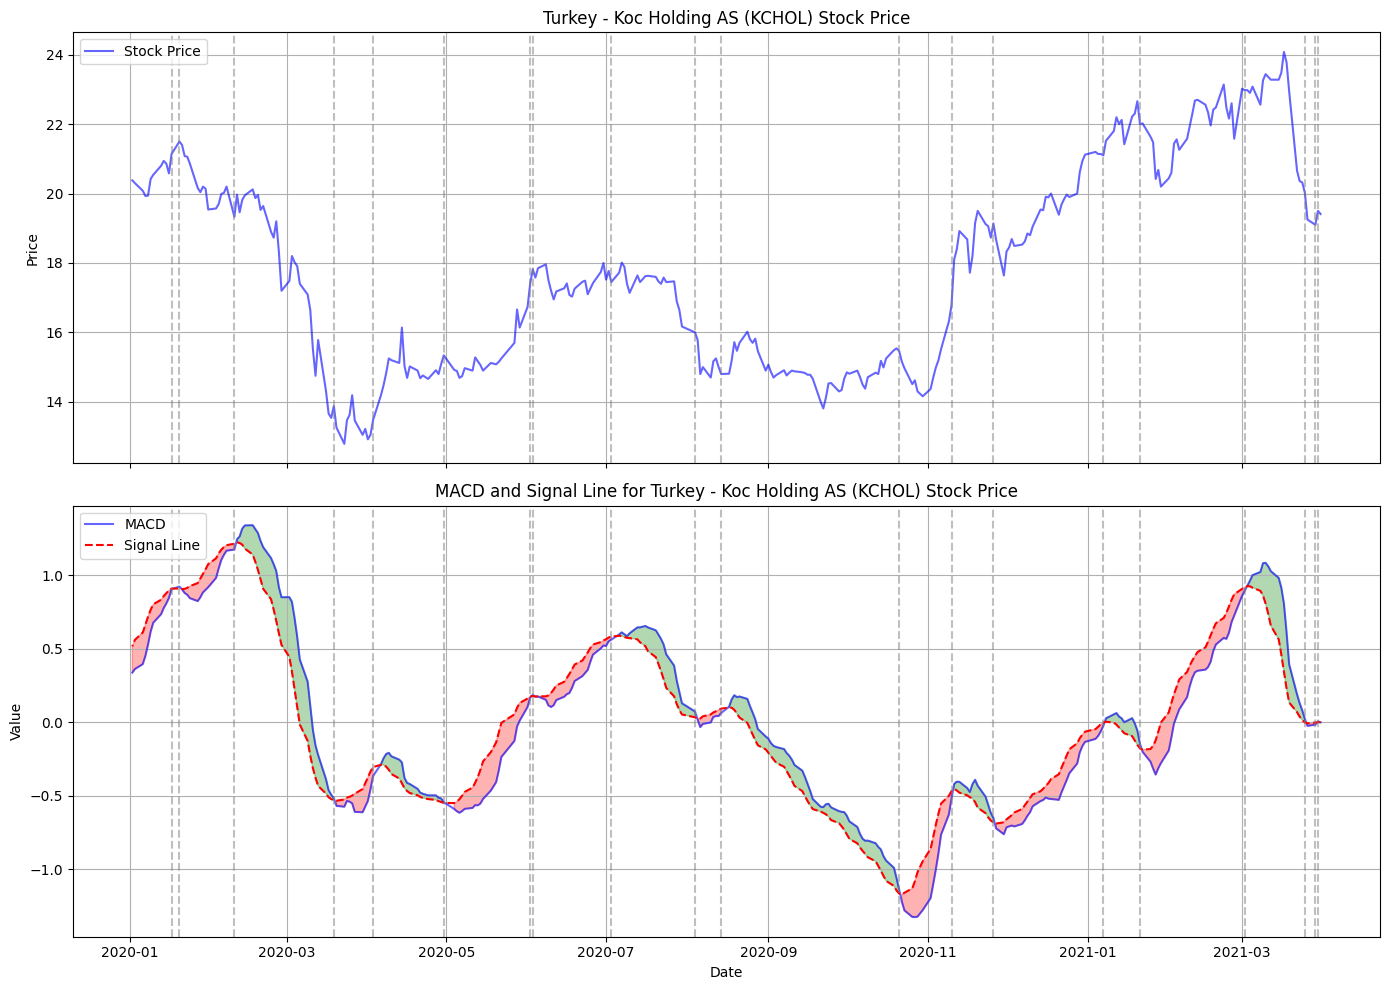

In [23]:
# Calculate the Short Term Exponential Moving Average
KCHOL_data['14_EMA'] = KCHOL_data['Price'].ewm(span=14, adjust=False).mean()

# Calculate the Long Term Exponential Moving Average
KCHOL_data['30_EMA'] = KCHOL_data['Price'].ewm(span=30, adjust=False).mean()

# Calculate MACD
KCHOL_data['MACD'] = KCHOL_data['14_EMA'] - KCHOL_data['30_EMA']

# Calculate Signal Line
KCHOL_data['Signal_Line'] = KCHOL_data['MACD'].ewm(span=9, adjust=False).mean()

#plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plotting the stock price on the first subplot
ax1.plot(KCHOL_data['Date'], KCHOL_data['Price'], label='Stock Price', color='blue', alpha=0.6)
ax1.set_title('Turkey - Koc Holding AS (KCHOL) Stock Price' )
ax1.set_ylabel('Price')
ax1.grid(True)
ax1.legend(loc='upper left')

# Plotting the MACD and Signal Line on the second subplot
ax2.plot(KCHOL_data['Date'], KCHOL_data['MACD'], label='MACD', color='blue', alpha=0.6)
ax2.plot(KCHOL_data['Date'], KCHOL_data['Signal_Line'], label='Signal Line', color='red', linestyle='--')

# Highlighting the area where MACD is above the signal line (potential buy zone)
ax2.fill_between(KCHOL_data['Date'], KCHOL_data['MACD'], KCHOL_data['Signal_Line'], where=(KCHOL_data['MACD'] > KCHOL_data['Signal_Line']), color='green', alpha=0.3)

# Highlighting the area where MACD is below the signal line (potential sell zone)
ax2.fill_between(KCHOL_data['Date'], KCHOL_data['MACD'], KCHOL_data['Signal_Line'], where=(KCHOL_data['MACD'] <= KCHOL_data['Signal_Line']), color='red', alpha=0.3)

# Identify intersection points
crossings = ((KCHOL_data['MACD'] > KCHOL_data['Signal_Line']) & (KCHOL_data['MACD'].shift(1) <= KCHOL_data['Signal_Line'].shift(1))) | ((KCHOL_data['MACD'] < KCHOL_data['Signal_Line']) & (KCHOL_data['MACD'].shift(1) >= KCHOL_data['Signal_Line'].shift(1)))

# Plot vertical lines on both subplots at the intersection points
# Visually indicates potential 'action' points of buy/sell
for date in KCHOL_data['Date'][crossings]:
    ax1.axvline(x=date, color='gray', linestyle='--', alpha=0.5)
    ax2.axvline(x=date, color='gray', linestyle='--', alpha=0.5)


ax2.set_title('MACD and Signal Line for Turkey - Koc Holding AS (KCHOL) Stock Price' )
ax2.set_xlabel('Date')
ax2.set_ylabel('Value')
ax2.grid(True)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

ACF (AutoCorrelation Function) and PACF (Partial AutoCorrelation Function)

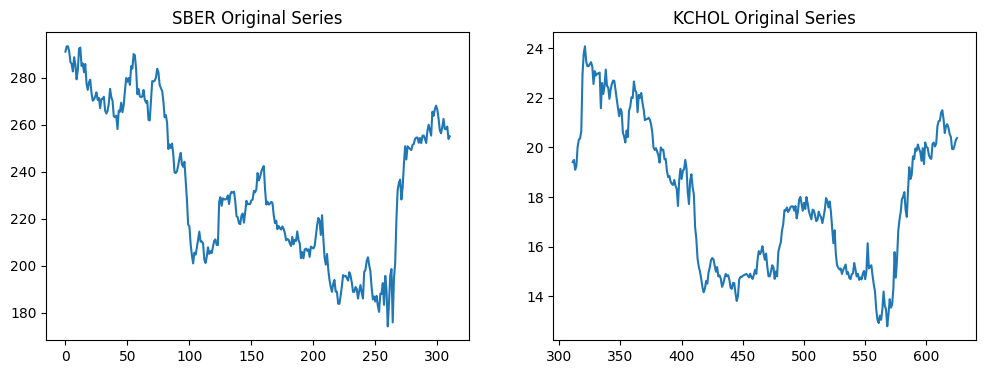

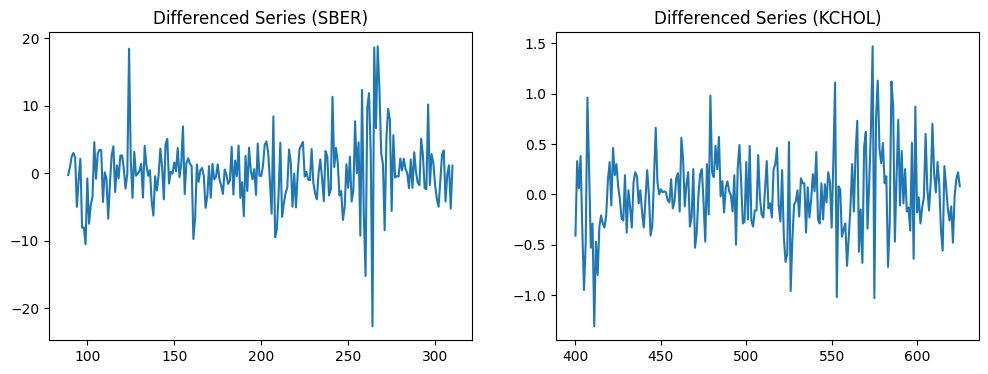

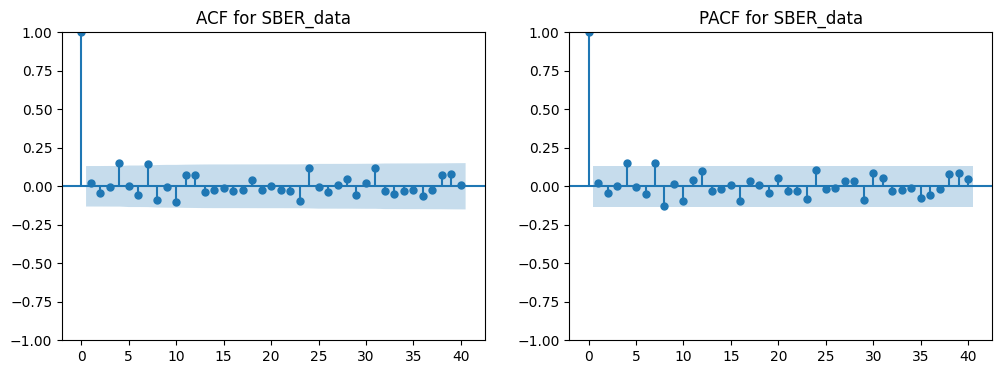

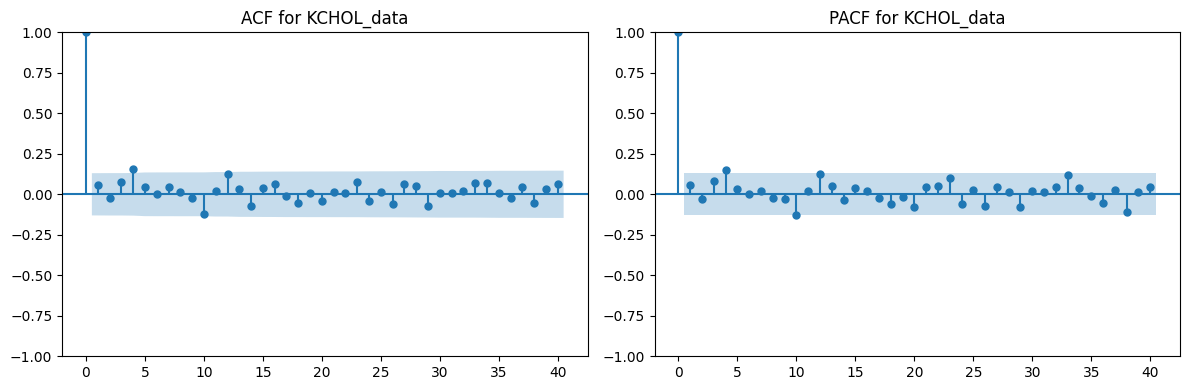

In [24]:

# Original Series
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(SBER_data['Price'])
ax1.set_title('SBER Original Series')
ax2.plot(KCHOL_data['Price'])
ax2.set_title('KCHOL Original Series')

# First differencing to make the series stationary
SBER_data['Price_Diff'] = SBER_data['Price'].diff()
KCHOL_data['Price_Diff'] = KCHOL_data['Price'].diff()
# Drop NaN values introduced by differencing
SBER_data.dropna(inplace=True)
KCHOL_data.dropna(inplace=True)

# Plot differenced time series
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(SBER_data['Price_Diff'])
ax1.set_title('Differenced Series (SBER)')
ax2.plot(KCHOL_data['Price_Diff'])
ax2.set_title('Differenced Series (KCHOL)')

# Plot ACF and PACF to help decide on p and q
# Plot ACF and PACF for SBER_data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(SBER_data['Price_Diff'], lags=40, ax=ax1)
plot_pacf(SBER_data['Price_Diff'], lags=40, ax=ax2)
ax1.set_title('ACF for SBER_data')
ax2.set_title('PACF for SBER_data')

# Create a new figure for KCHOL_data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(KCHOL_data['Price_Diff'], lags=40, ax=ax1)
plot_pacf(KCHOL_data['Price_Diff'], lags=40, ax=ax2)
ax1.set_title('ACF for KCHOL_data')
ax2.set_title('PACF for KCHOL_data')

plt.tight_layout()
plt.show()

**Data Splitting**

Split data into training(2020) and testing (2021 Q1) sets

In [25]:
# Split the data into training and test sets
train = df[df['Date'].dt.year == 2020]
test = df[df['Date'].dt.year == 2021]

#ARIMA-Model Development

**Model Selection**

Models like ARIMA, Prophet, LSTM, and other time series forecasting models can be considered.

Use cross-validation on the training set to tune hyperparameters.



In [26]:
# Train and Test function, so that we can pass multiple companies .
def train_test_company(company_name, train, test, p, d, q):
    # Filter data for the given company and ensure it's sorted by date
    train_data = train[train['Company'] == company_name].sort_values(by='Date')
    test_data = test[test['Company'] == company_name].sort_values(by='Date')

    # Ensure the 'Date' column is in datetime format
    train_data['Date'] = pd.to_datetime(train_data['Date'])
    test_data['Date'] = pd.to_datetime(test_data['Date'])

    # Fit the ARIMA Model on the training data
    model = ARIMA(train_data['Price'], order=(p, d, q))
    results = model.fit()

    # Forecast the values for the test set duration
    forecast = results.forecast(steps=len(test_data))

    # Evaluate the model's performance
    mse = mean_squared_error(test_data['Price'], forecast)
    rmse = np.sqrt(mse)
    print(f"Company: {company_name}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Plot the actual vs. predicted values
    plt.figure(figsize=(14, 7))
    plt.plot(train_data['Date'], train_data['Price'], label='Training Data', color='blue', alpha=0.6)
    plt.plot(test_data['Date'], test_data['Price'], label='Actual Test Data', color='green', alpha=0.6)
    plt.plot(test_data['Date'], forecast, label='ARIMA Forecast', color='red', linestyle='--')
    plt.title(f'ARIMA Model Forecast vs Actuals for {company_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [27]:
# Optimization function to determine pdq
def arima_grid_search_for_company(company_name, train, p_values, d_values, q_values):
    # Filter training data for the given company
    train_data = train[train['Company'] == company_name]['Price']

    best_aic = float("inf")
    best_order = None
    best_model = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(train_data, order=order)
                    results = model.fit()
                    # Check if the current model's AIC is lower than the previous best
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = order
                        best_model = results
                except:
                    continue

    return company_name, best_order, best_aic

In [28]:
# Define the range of values for p, d, q
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Company', 'Best_Order', 'Best_AIC'])

# Loop through all companies and save the results in the DataFrame
for company in train['Company'].unique():
    company_name, best_order, best_aic = arima_grid_search_for_company(company, train, p_values, d_values, q_values)
    results_df.loc[len(results_df)] = [company_name, best_order, best_aic]



# Display the results
print(results_df)


                           Company Best_Order     Best_AIC
0  Russia - Sberbank Rossii PAO (S  (2, 1, 2)  1495.338825
1  Turkey - Koc Holding AS (KCHOL)  (0, 1, 0)   252.962985


**Model Training** and **Evaluation**

Company: Russia - Sberbank Rossii PAO (S
Root Mean Squared Error (RMSE): 10.151046308631035


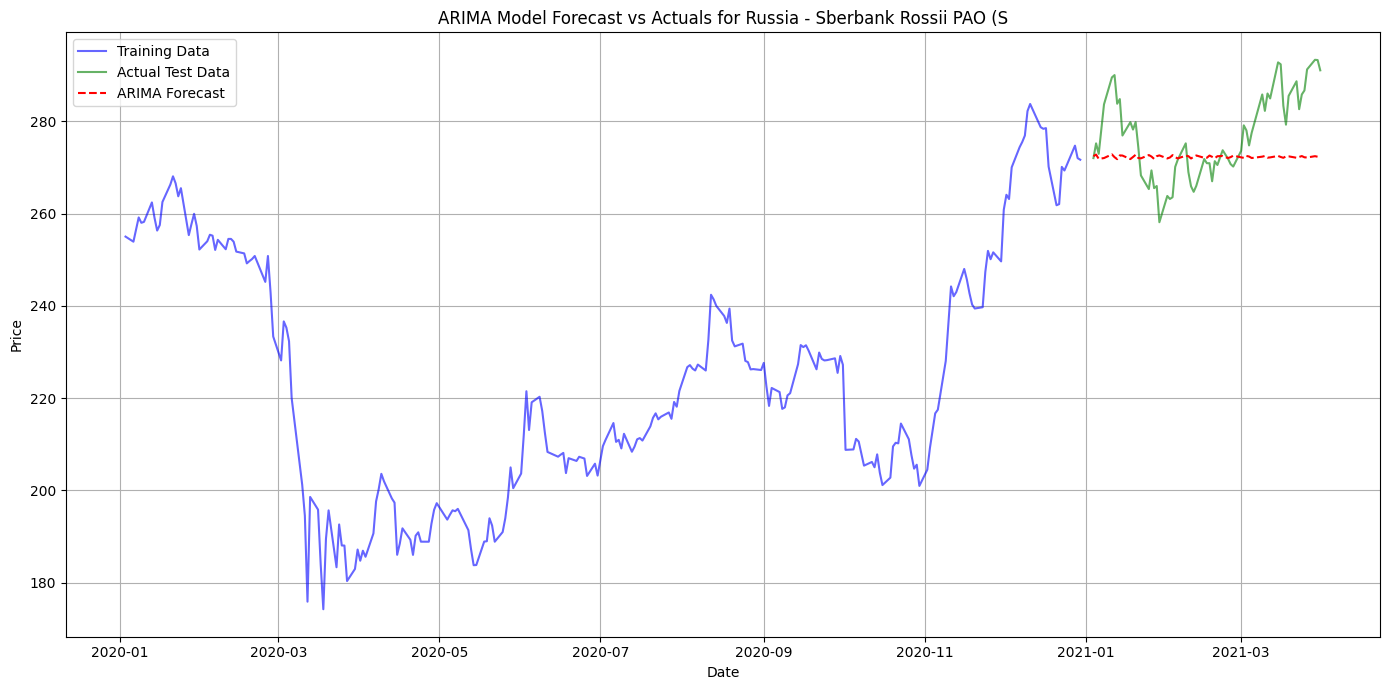

Company: Turkey - Koc Holding AS (KCHOL)
Root Mean Squared Error (RMSE): 1.3917705977729935


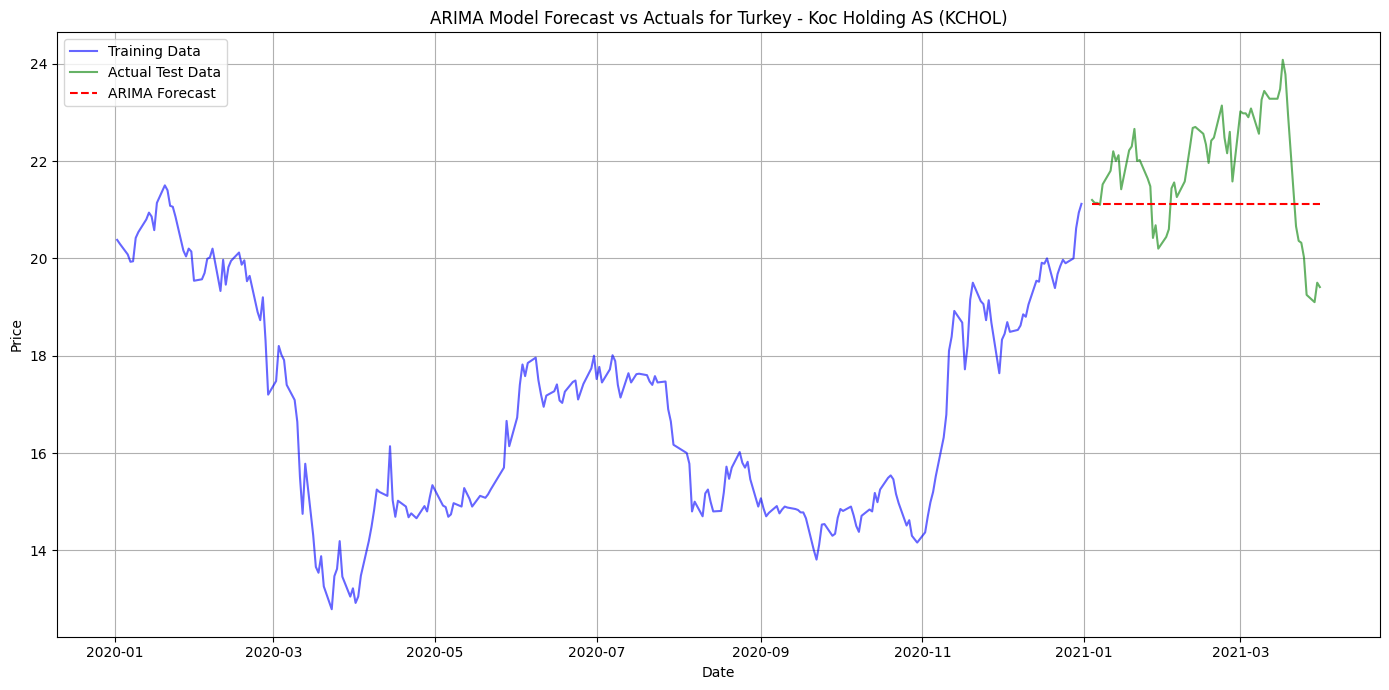

In [29]:
#!pip install --upgrade statsmodels
# Loop through each row in results_df
for index, row in results_df.iterrows():
    company_name = row['Company']
    best_order = row['Best_Order']

    # Use the train_test_company function for each company
    train_test_company(company_name, train, test, *best_order)

#**LSTM Model**

In [30]:
def lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse') #compile the model
    model.save("my_lstm_model.h5")
    return model


In [31]:
def train_lstm_model(company, train, model):
    # Filter and preprocess the data
    train_data = train[train['Company'] == company]['Price'].values.reshape(-1, 1)
    test_data = test[test['Company'] == company]['Price'].values.reshape(-1, 1)



     # Normalize the data
    #scaler = MinMaxScaler()
    #train_data_normalized = scaler.fit_transform(train_data)


    # Create sequences
    X_train = []
    y_train = []
    for i in range(60, len(train_data)):  # Using a sequence length of 60
        X_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)


    # Reshape for LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=32,verbose=0)

    return model #scaler


In [32]:
def predict_and_plot(company, train, test, model):
    # Filter the training and testing data for the specified company
    train_data = train[train['Company'] == company]['Price'].values.reshape(-1, 1)
    test_data = test[test['Company'] == company]['Price'].values.reshape(-1, 1)

    forecast_list = []
    number_of_days_forecast = 60

    for i in range(len(test_data)):
        if i == 0:
            # For the first day, predict using the last 60 days of training data
            forecast = model.predict(train_data[-60:].reshape(1, -1))[0][0]
        else:
            # For subsequent days, combine training data with forecasted data and predict
            combined_data = np.concatenate((train_data, np.array(forecast_list).reshape(-1, 1)))
            forecast = model.predict(combined_data[-60:].reshape(1, -1))[0][0]

        forecast_list.append(forecast)


    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(train_data, label='Training Data')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test Data')
    forecast_range = range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(forecast_list))
    plt.plot(forecast_range, forecast_list, label='Forecasted Data')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(f'Stock Price Forecast for {company}')
    plt.legend()
    plt.show()


**Model Evaluation**

1/1 [==============================] - 0s 31ms/step


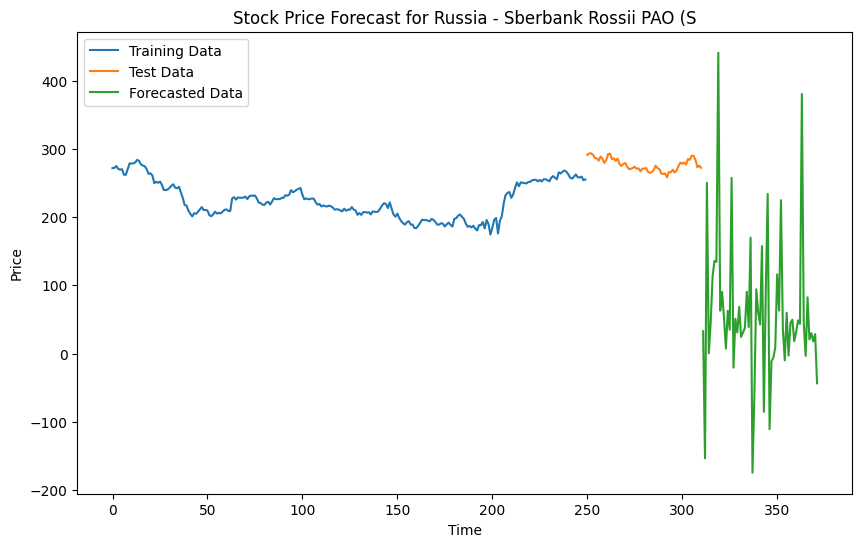

1/1 [==============================] - 0s 25ms/step


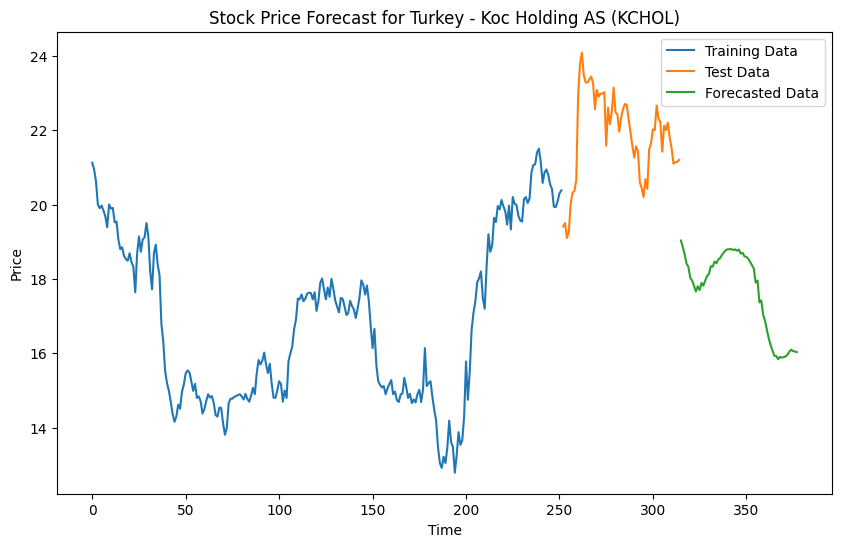

In [33]:

  ## List to store unique company names
companies = []

# Iterate over unique company names and train/predict for each company
for company in train['Company'].unique():
    input_shape = (60, 1)  # 60 time steps with 1 feature
    model= lstm_model(input_shape)

    # Train the model
    model= train_lstm_model(company, train, model)

    # Predict and plot
    predict_and_plot(company, train, test, model)

    companies.append(company)



#Prophet Model

In [34]:
#!pip install prophet
#!pip install yfinance


Importing the Libraries

In [35]:
#IMPORTING ALL THE NECESSARY PACKAGES.
import plotly.express as px
from prophet import Prophet                                                   #Importing prophet (prediction and forecasting library.)
import yfinance as yf
from prophet import plot

from sklearn.metrics import mean_absolute_error

The YFinance is an API tool that  the ticker name, start time, and end time as parameters and will return the historical data of that stock between the defined period.

In [36]:
data=df.copy()

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     626 non-null    datetime64[ns]
 1   Price    626 non-null    float64       
 2   Company  626 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 14.8+ KB


In [38]:
#covert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'])

In [39]:

#visualize price
fig = px.line(data, x='Date', y='Price', color='Company', title='Stock Prices for Two Companies')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [40]:
#prepare the data
#Prophet requires specific column names ('ds' for dates and 'y' for the target variable).
data = data.rename(columns={'Date': 'ds', 'Price': 'y'})



In [41]:
# Split the data into training and test sets
train_data_SBER = data[(data['ds'].dt.year == 2020) & (data['Company'] == 'Russia - Sberbank Rossii PAO (S')]
test_data_SBER = data[(data['ds'].dt.year == 2021) & (data['Company'] == 'Russia - Sberbank Rossii PAO (S')]

# Split the data for company B into training and test sets for the years 2020 and 2021.
train_data_KCHOL = data[(data['ds'].dt.year == 2020) & (data['Company'] == 'Turkey - Koc Holding AS (KCHOL)')]
test_data_KCHOL = data[(data['ds'].dt.year == 2021) & (data['Company'] == 'Turkey - Koc Holding AS (KCHOL)')]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfz7dgcov/s0ydqzbh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfz7dgcov/a3z7e1ox.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80128', 'data', 'file=/tmp/tmpfz7dgcov/s0ydqzbh.json', 'init=/tmp/tmpfz7dgcov/a3z7e1ox.json', 'output', 'file=/tmp/tmpfz7dgcov/prophet_modelh8icy4hg/prophet_model-20231019084345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:43:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:43:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Error:
45.97836065573771


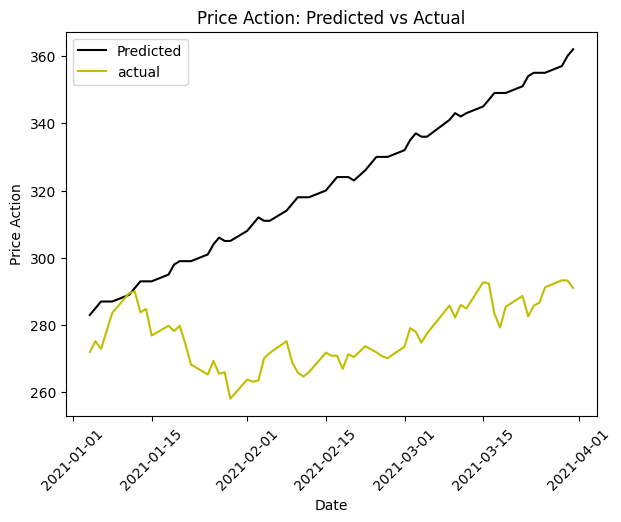

           ds        yhat  yhat_lower  yhat_upper
56 2021-03-25  355.425506  329.816718  380.507899
57 2021-03-26  355.494245  329.592715  379.919495
58 2021-03-29  357.844364  331.627511  381.233498
59 2021-03-30  360.292079  332.259010  387.046653
60 2021-03-31  362.078805  334.339564  389.193233


In [84]:
#Russi Bank
model = Prophet(daily_seasonality=True)
model.fit(train_data_SBER)
y_actual = test_data_SBER['y']

prediction = model.predict(pd.DataFrame({'ds':test_data_SBER['ds']}))
y_predicted = prediction['yhat']
y_predicted = y_predicted.astype(int)

print("Mean Absolute Error:")
print(mean_absolute_error(y_actual, y_predicted))

#visualize the predicted and actual values

plt.plot(prediction['ds'], y_predicted, 'k',label='Predicted')
plt.plot(test_data_SBER['ds'], y_actual, 'y',label='actual')
plt.xlabel("Date")
plt.ylabel("Price Action")
plt.title("Price Action: Predicted vs Actual")
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

print(prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


In [43]:
#Turkey Bank
model1 = Prophet(daily_seasonality=True)
model1.fit(train_data_KCHOL)
y_actual = test_data_KCHOL['y']

prediction = model1.predict(pd.DataFrame({'ds':test_data_KCHOL['ds']}))
y_predicted = prediction['yhat']
y_predicted = y_predicted.astype(int)

print("Mean Absolute Error:")
print(mean_absolute_error(y_actual, y_predicted))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfz7dgcov/rqrhr9at.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfz7dgcov/hex37f9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64796', 'data', 'file=/tmp/tmpfz7dgcov/rqrhr9at.json', 'init=/tmp/tmpfz7dgcov/hex37f9r.json', 'output', 'file=/tmp/tmpfz7dgcov/prophet_modelgnz9iyw4/prophet_model-20231019080216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:02:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:02:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


2.35936507936508

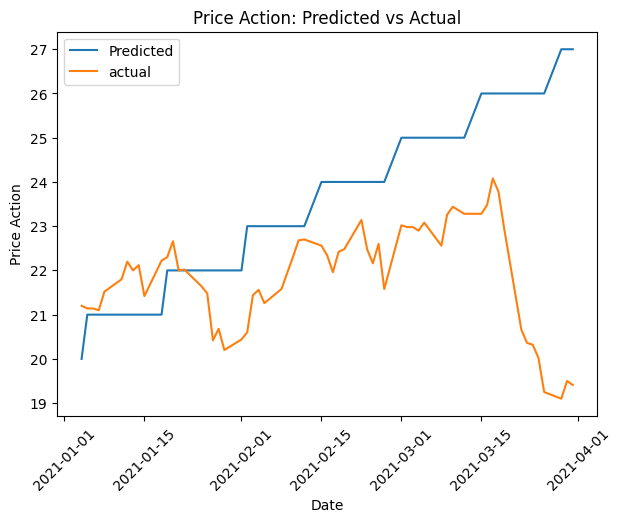

           ds       yhat  yhat_lower  yhat_upper
58 2021-03-25  26.940675   24.155050   29.521329
59 2021-03-26  26.967076   24.217353   29.737255
60 2021-03-29  27.151100   24.319409   29.854981
61 2021-03-30  27.317911   24.305894   30.131474
62 2021-03-31  27.353632   24.448082   30.179354


In [83]:
#visualize the predicted and actual values
plt.plot(prediction['ds'], y_predicted,label='Predicted')
plt.plot(test_data_KCHOL['ds'], y_actual,label='actual')
plt.xlabel("Date")
plt.ylabel("Price Action")
plt.title("Price Action: Predicted vs Actual")
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

print(prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfz7dgcov/g9lafwnw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfz7dgcov/eyj9igk4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40234', 'data', 'file=/tmp/tmpfz7dgcov/g9lafwnw.json', 'init=/tmp/tmpfz7dgcov/eyj9igk4.json', 'output', 'file=/tmp/tmpfz7dgcov/prophet_modeluyiycbhf/prophet_model-20231019080216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:02:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:02:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


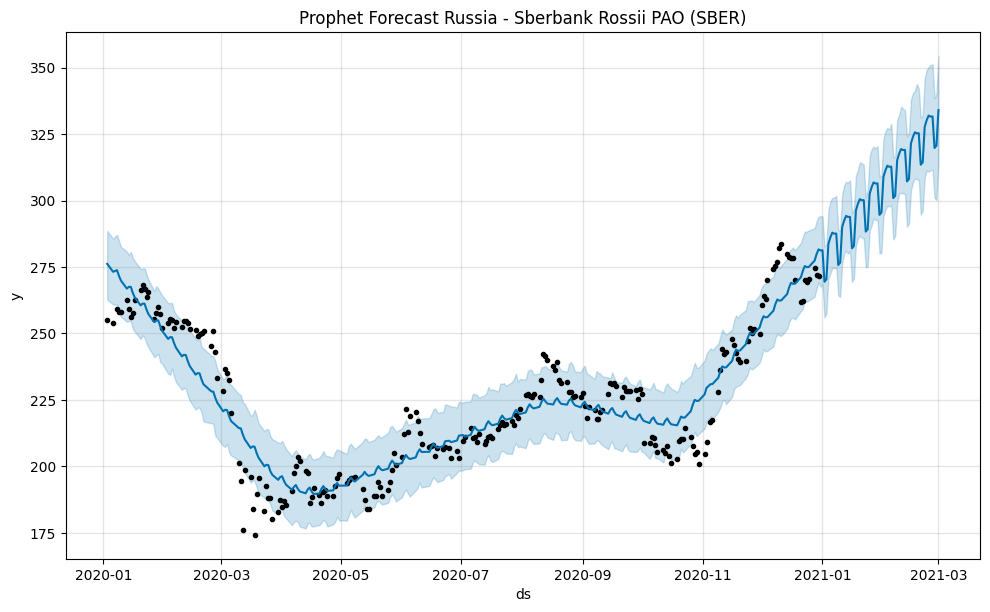

In [45]:
#Price Action Forecast
model = Prophet()                                                               #creating an instant of prophet class in model.
model.fit(train_data_SBER)                                                           #fitting data_frame to the model.
future = model.make_future_dataframe(len(test_data_SBER))
forecast = model.predict(future)                                                #using predict function of python, predicting the values for future data values and storing it in forecast.
model.plot(forecast)
plt.title('Prophet Forecast Russia - Sberbank Rossii PAO (SBER)')                                                            #plotting the values in forecast using atplotlib.
plt.show()

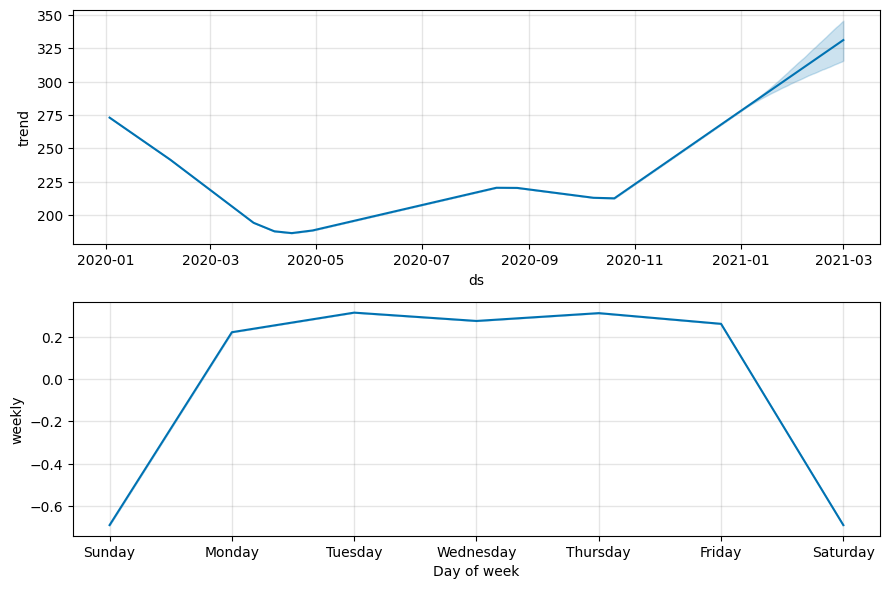

In [78]:
fig1 = model.plot_components(forecast)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfz7dgcov/6fe2t52v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfz7dgcov/ec66d0ep.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68853', 'data', 'file=/tmp/tmpfz7dgcov/6fe2t52v.json', 'init=/tmp/tmpfz7dgcov/ec66d0ep.json', 'output', 'file=/tmp/tmpfz7dgcov/prophet_modele7zebsla/prophet_model-20231019080217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:02:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:02:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


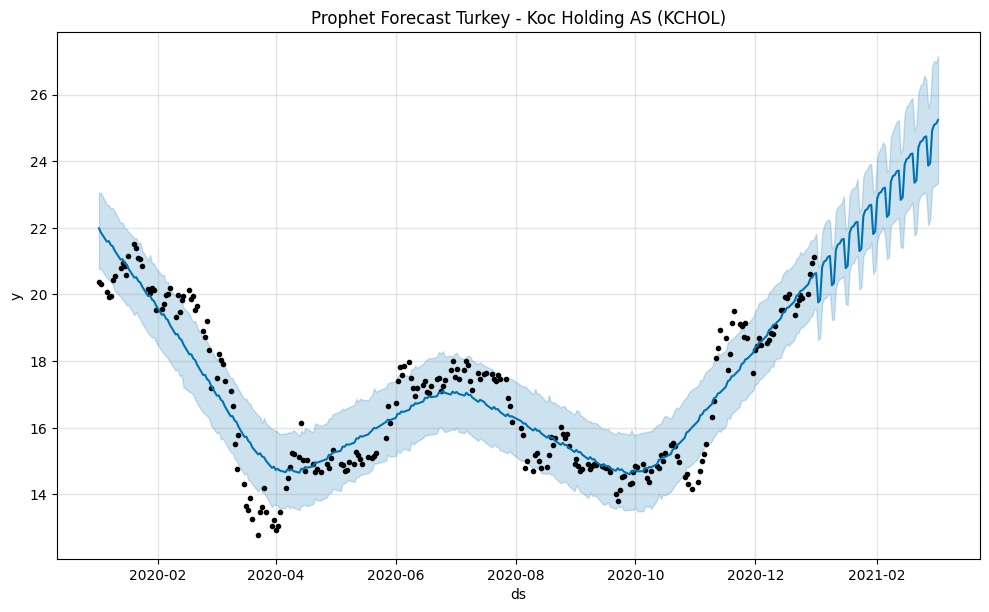

In [47]:
model = Prophet()                                                               #creating an instant of prophet class in model.
model.fit(train_data_KCHOL)                                                           #fitting data_frame to the model.
future = model.make_future_dataframe(len(test_data_KCHOL))                                       #making future dataframe.
forecast1 = model.predict(future)                                                #using predict function of python, predicting the values for future data values and storing it in forecast.
model.plot(forecast1)
plt.title('Prophet Forecast Turkey - Koc Holding AS (KCHOL)')                                                            #plotting the values in forecast using atplotlib.
plt.show()

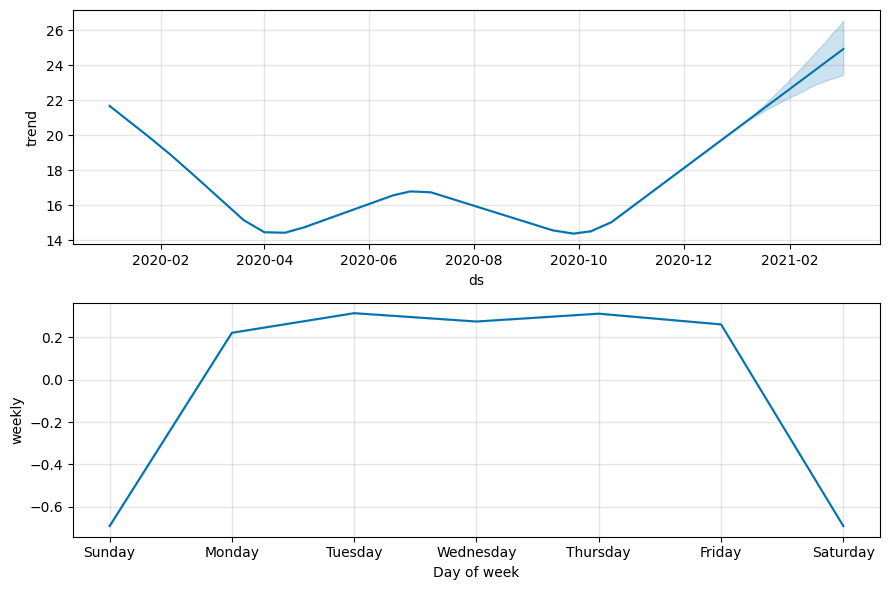

In [77]:
fig2 = model.plot_components(forecast1)

#Calculating Bolinger Bands after the Forecasting

The Bollinger Bands is a technical indicator that is plotted two standard deviations, both positively and negatively, away from a simple moving average (SMA) of a price

In [73]:
#data
SBER_data = data[data['Company'] == 'Russia - Sberbank Rossii PAO (S'].copy()
KCHOL_data = data[data['Company'] == 'Turkey - Koc Holding AS (KCHOL)'].copy()

In [74]:
SBER_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311 entries, 0 to 310
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ds       311 non-null    datetime64[ns]
 1   y        311 non-null    float64       
 2   Company  311 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 9.7+ KB


In [76]:
#reset the index
KCHOL_data=KCHOL_data.reset_index(drop=True)
KCHOL_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ds       315 non-null    datetime64[ns]
 1   y        315 non-null    float64       
 2   Company  315 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 7.5+ KB


**Bollinger Band for Rusian Bank**

In [87]:
# def Moving Average (SMA)
def moving_averages(df, window):
    return df['yhat'].rolling(window=window).mean()

window = 61  # Number of periods for moving average and standard deviation
forecast['SMA'] = moving_averages(forecast, window)
forecast['Std'] = forecast['yhat'].rolling(window).std()

forecast['upper_band'] = forecast['SMA'] + (forecast['Std']*2)
forecast['lower_band'] = forecast['SMA'] - (forecast['Std']*2)



LONG - 2020-10-01 00:00:00: Long position opened at 214.19
CLOSE - 2020-10-23 00:00:00: Position closed at 215.31
SHORT - 2020-11-09 00:00:00: Short position opened at 230.58
CLOSE - 2020-11-27 00:00:00: Position closed at 246.76
SHORT - 2020-11-30 00:00:00: Short position opened at 249.46
CLOSE - 2020-12-02 00:00:00: Position closed at 251.25
Final capital: 10979.17


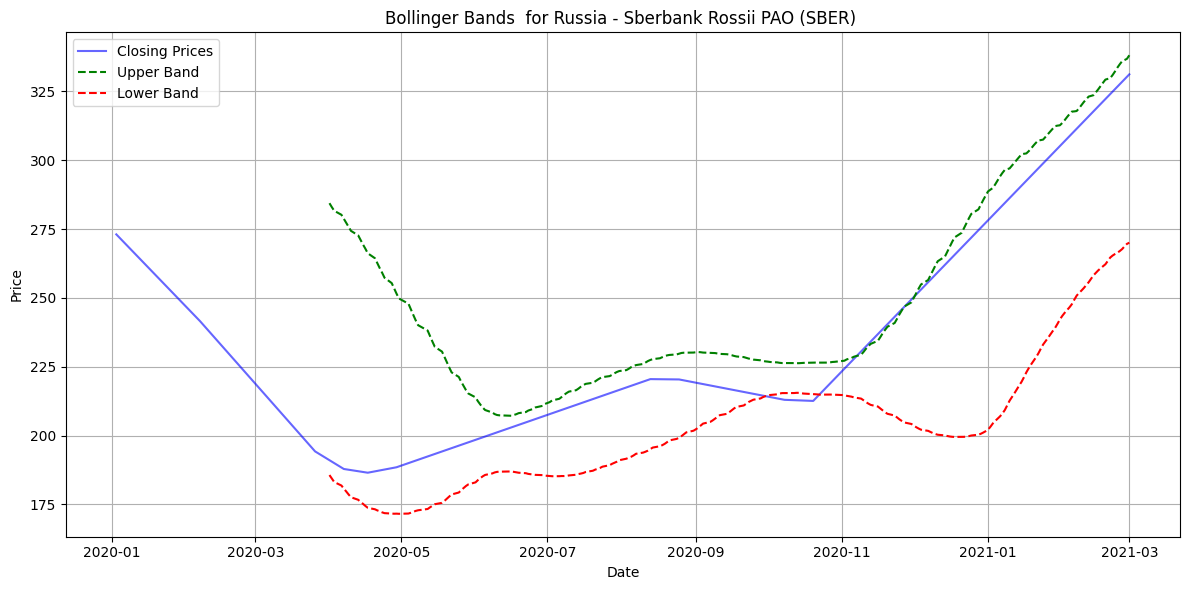

In [91]:
# Trading strategy based on Bollinger Bands
capital = 10000  # Initial capital
position = 0  # 0: No position, 1: Buy position, -1: Short position

for index, row in forecast.iterrows():
    if row['trend'] > row['upper_band']:
        if position != -1:  # Avoid multiple short positions
            position = -1
            capital += row['trend']
            print(f"SHORT - {row['ds']}: Short position opened at {row['trend']:.2f}")
    elif row['trend'] < row['lower_band']:
        if position != 1:  # Avoid multiple long positions
            position = 1
            capital -= row['trend']
            print(f"LONG - {row['ds']}: Long position opened at {row['trend']:.2f}")
    elif position != 0:
        capital += row['trend']
        position = 0
        print(f"CLOSE - {row['ds']}: Position closed at {row['trend']:.2f}")

# Close any remaining position at the end
if position != 0:
    capital += df.iloc[-1]['trend']
    print(f"Final position closed at {df.iloc[-1]['trend']:.2f}")

print(f"Final capital: {capital:.2f}")

# Plotting Bollinger Bands and closing prices
plt.figure(figsize=(12, 6))
plt.plot(forecast['ds'], forecast['trend'], label='Closing Prices', color='blue', alpha=0.6) # Plotting the forecasted closing prices
plt.plot(forecast['ds'], forecast['upper_band'], label='Upper Band', color='green', linestyle='--')
plt.plot(forecast['ds'], forecast['lower_band'], label='Lower Band', color='red', linestyle='--')
plt.title('Bollinger Bands  for Russia - Sberbank Rossii PAO (SBER) ')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

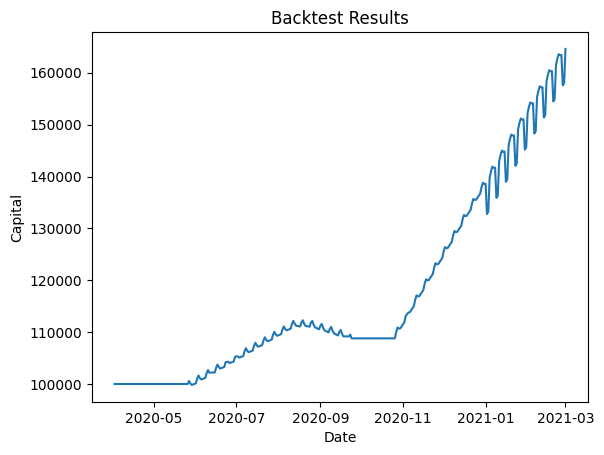

In [99]:
# Generate buy/sell/hold recommendations based on forecast and moving averages
forecast['signal'] = 1  # 0: HOLD, 1: BUY, -1: SELL

for i in range(window, len(forecast)):
    if forecast['yhat'][i] > forecast['SMA'][i]:
        forecast.loc[i, 'signal'] = 1
    elif forecast['yhat'][i] < forecast['SMA'][i]:
        forecast.loc[i, 'signal'] = -1

# Backtesting the strategy
capital = 100000  # Initial capital
shares_held = 0
capital_history = []

for i in range(window, len(forecast)):
    if forecast['signal'][i] == 1 and capital > 0:
        shares_held = capital / forecast['yhat'][i]
        capital = 0
    elif forecast['signal'][i] == -1 and shares_held > 0:
        capital = shares_held * forecast['yhat'][i]
        shares_held = 0

    capital_history.append(capital + shares_held * forecast['yhat'][i])

# Plot the backtest results
plt.plot(forecast['ds'][window:], capital_history)
plt.xlabel('Date')
plt.ylabel('Capital')
plt.title('Backtest Results')
plt.show()

**Bollinger Bands for the Turkey Bank**

In [89]:
# def moving average function
def moving_averages(df, window):
    return df['yhat'].rolling(window=window).mean()

window = 61  # Number of periods for moving average and standard deviation
forecast1['SMA'] = moving_averages(forecast1, window)
forecast1['Std'] = forecast1['yhat'].rolling(window).std()

forecast1['upper_band'] = forecast1['SMA'] + (forecast1['Std']*2)
forecast1['lower_band'] = forecast1['SMA'] - (forecast1['Std']*2)

LONG - 2020-08-12 00:00:00: Long position opened at 15.64
CLOSE - 2020-09-21 00:00:00: Position closed at 14.49
SHORT - 2020-11-09 00:00:00: Short position opened at 16.50
CLOSE - 2020-11-25 00:00:00: Position closed at 17.67
Final capital: 10033.02


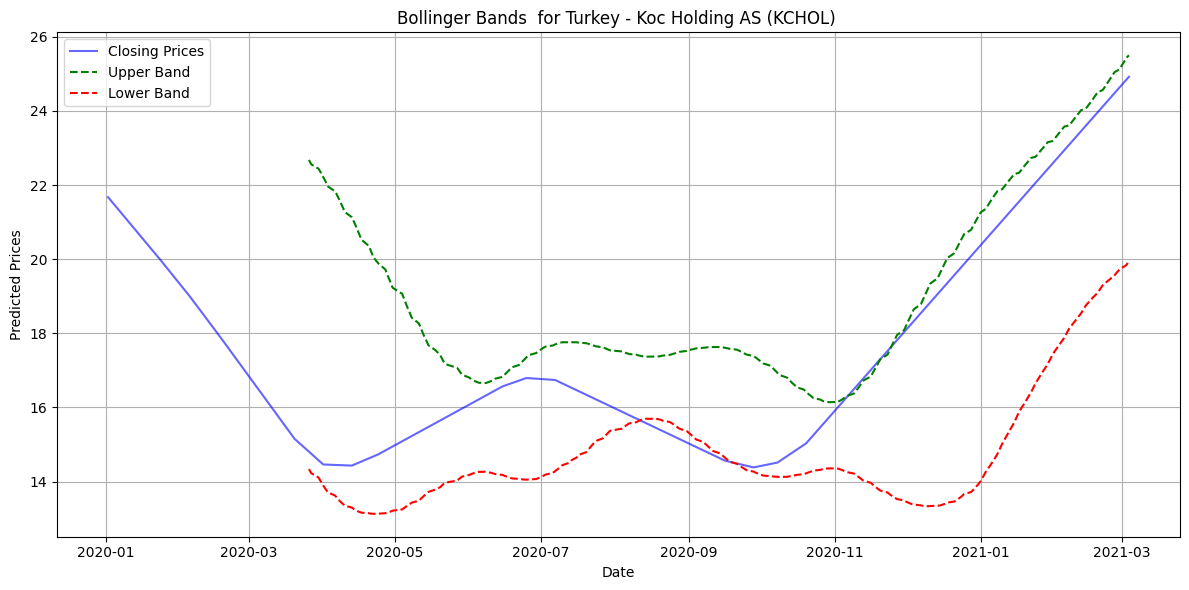

In [92]:
# Trading strategy based on Bollinger Bands
capital = 10000  # Initial capital
position = 0  # 0: No position, 1: Buy position, -1: Short position

for index, row in forecast1.iterrows():
    if row['trend'] > row['upper_band']:
        if position != -1:  # Avoid multiple short positions
            position = -1
            capital += row['trend']
            print(f"SHORT - {row['ds']}: Short position opened at {row['trend']:.2f}")
    elif row['trend'] < row['lower_band']:
        if position != 1:  # Avoid multiple long positions
            position = 1
            capital -= row['trend']
            print(f"LONG - {row['ds']}: Long position opened at {row['trend']:.2f}")
    elif position != 0:
        capital += row['trend']
        position = 0
        print(f"CLOSE - {row['ds']}: Position closed at {row['trend']:.2f}")

# Close any remaining position at the end
if position != 0:
    capital += df.iloc[-1]['trend']
    print(f"Final position closed at {df.iloc[-1]['trend']:.2f}")

print(f"Final capital: {capital:.2f}")


# Plotting Bollinger Bands and closing prices
plt.figure(figsize=(12, 6))
plt.plot(forecast1['ds'], forecast1['trend'], label='Closing Prices', color='blue', alpha=0.6)
plt.plot(forecast1['ds'], forecast1['upper_band'], label='Upper Band', color='green', linestyle='--')
plt.plot(forecast1['ds'], forecast1['lower_band'], label='Lower Band', color='red', linestyle='--')


plt.title('Bollinger Bands  for Turkey - Koc Holding AS (KCHOL) ')
plt.xlabel('Date')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


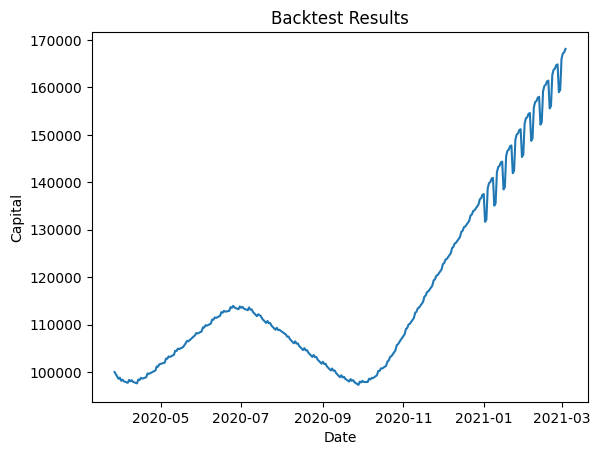

In [100]:
# Generate buy/sell/hold recommendations based on forecast and moving averages
forecast1['signal'] = 1  # 0: HOLD, 1: BUY, -1: SELL

for i in range(window, len(forecast1)):
    if forecast1['yhat'][i] > forecast1['SMA'][i]:
        forecast.loc[i, 'signal'] = 1
    elif forecast1['yhat'][i] < forecast1['SMA'][i]:
        forecast.loc[i, 'signal'] = -1

# Backtesting the strategy
capital = 100000  # Initial capital
shares_held = 0
capital_history = []

for i in range(window, len(forecast1)):
    if forecast1['signal'][i] == 1 and capital > 0:
        shares_held = capital / forecast1['yhat'][i]
        capital = 0
    elif forecast1['signal'][i] == -1 and shares_held > 0:
        capital = shares_held * forecast1['yhat'][i]
        shares_held = 0

    capital_history.append(capital + shares_held * forecast1['yhat'][i])

# Plot the backtest results
plt.plot(forecast1['ds'][window:], capital_history)
plt.xlabel('Date')
plt.ylabel('Capital')
plt.title('Backtest Results')
plt.show()

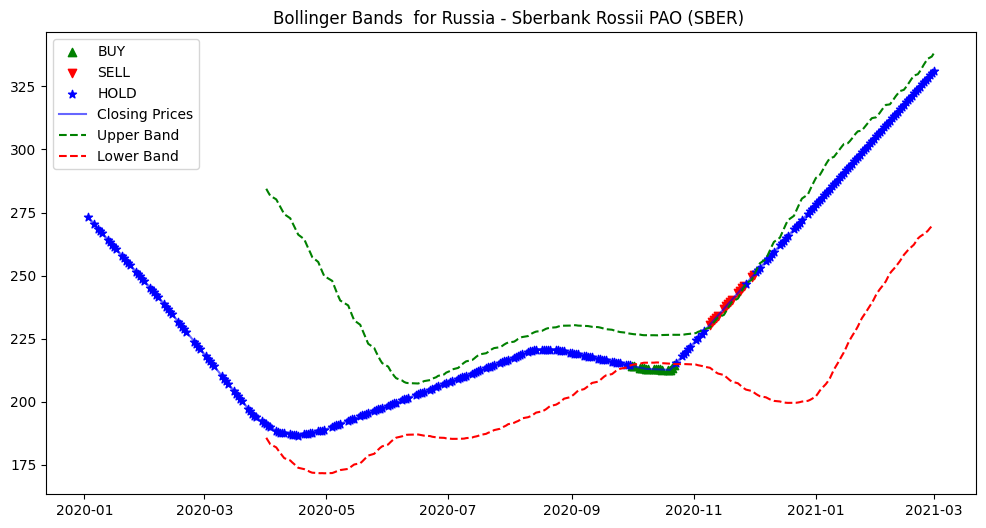

In [ ]:
buy_signal = [] #buy list
sell_signal = [] #sell list
hold_signal = [] # hold list


for i in range(len(forecast['trend'])):
    if forecast['trend'].values[i] > forecast['upper_band'].values[i]: #Then you should sell
            buy_signal.append(np.nan)
            sell_signal.append(forecast['trend'][i])
            hold_signal.append(np.nan)
    elif forecast['trend'].values[i] < forecast['lower_band'].values[i]: #Then you should buy
            sell_signal.append(np.nan)
            buy_signal.append(forecast['trend'][i])
            hold_signal.append(np.nan)
    else:
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
            hold_signal.append(forecast['trend'][i]) #Then you should hold

#labels_df = pd.DataFrame(list(zip(buy_signal, sell_signal, hold_signal)), columns=['buy_signal', 'sell_signal', 'hold_signal'])
plt.figure(figsize=(12, 6))
plt.scatter(forecast['ds'], buy_signal, marker = '^', color = 'green', label = 'BUY',)
plt.scatter(forecast['ds'], sell_signal, marker = 'v', color = 'red', label = 'SELL', )
plt.scatter(forecast['ds'], hold_signal, marker = '*', color = 'blue', label = 'HOLD', )

plt.plot(forecast['ds'], forecast['trend'], label='Closing Prices', color='blue', alpha=0.6) # Plotting the forecasted closing prices
plt.plot(forecast['ds'], forecast['upper_band'], label='Upper Band', color='green', linestyle='--')
plt.plot(forecast['ds'], forecast['lower_band'], label='Lower Band', color='red', linestyle='--')
plt.title('Bollinger Bands  for Russia - Sberbank Rossii PAO (SBER) ')
plt.legend()
plt.show()